<a href="https://colab.research.google.com/github/CubatLin/Data-Processing-Methods/blob/master/%5BOpen%5D%20Logistics_solo_top1_solution_THU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Competition Link:
https://www.kaggle.com/c/open-shopee-code-league-logistic/overview
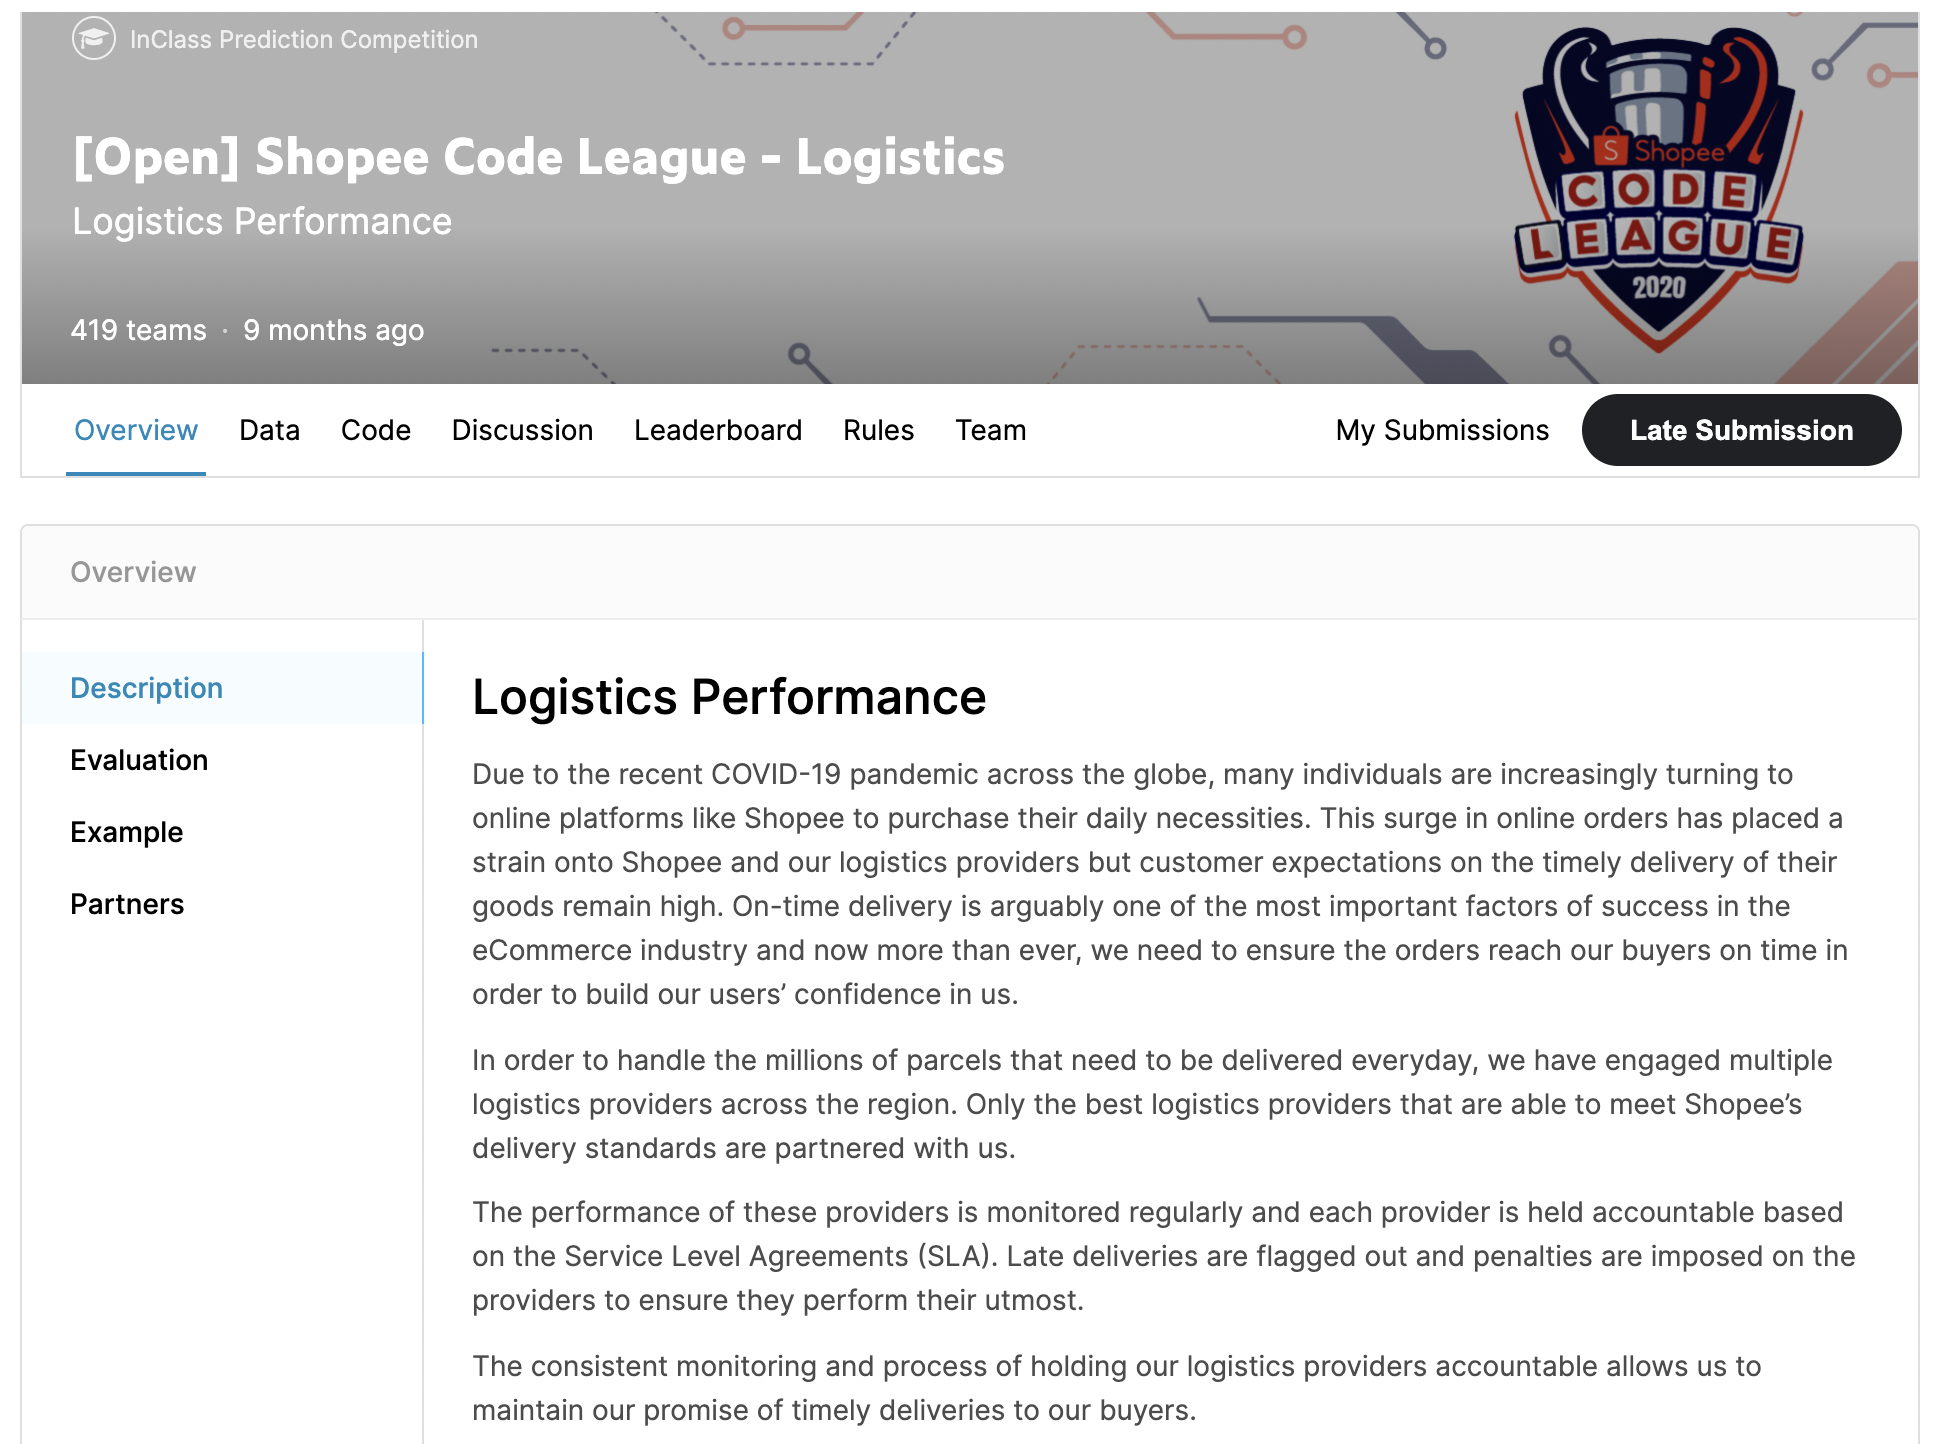

In [8]:
!gdown --id 1-FmBCCXsW9TYnwujTy2wtYthJvuywnKE

Downloading...
From: https://drive.google.com/uc?id=1-FmBCCXsW9TYnwujTy2wtYthJvuywnKE
To: /content/delivery_orders_march.csv
756MB [00:08, 84.4MB/s]


## Task
* Identify all the orders that are considered late depending on the Service Level Agreements (SLA) with our Logistics Provider.

* For the purpose of this question, assume that all deliveries are considered successful by the second attempt.

### Basic Concepts
* Each orderid represents a distinct transaction on Shopee.
* SLA can vary across each route (A route is defined as Seller’s Location to Buyer’s Location) - Refer to SLA_matrix.xlsx
* Pick Up Time is defined as the time when the 3PL picks up the parcel and begins to process for delivery. It marks the start of the SLA calculation.
* Delivery Attempt is defined as an attempt made by the 3PL to deliver the parcel to the customer. It may or may not be delivered successfully. In the case when it is unsuccessful, a 2nd attempt will be made. A parcel that has no 2nd attempt is deemed to have been successfully delivered on the 1st attempt.
* All time formats are stored in epoch time based on Local Time (GMT+8).
* Only consider the date when determining if the order is late; ignore the time.
* Working Days are defined as Mon - Sat, Excluding Public Holidays.
* SLA calculation begins from the next day after pickup (Day 0 = Day of Pickup; Day 1 = Next Day after Pickup)
* 2nd Attempt must be no later than 3 working days after the 1st Attempt, regardless of origin to destination route (Day 0 = Day of 1st Attempt; Day 1 = Next Day after 1st Attempt).

Only consider the date when determining if the order is late; ignore the time.

Assume the following Public Holidays: 

* 2020-03-08 (Sunday);
* 2020-03-25 (Wednesday);
* 2020-03-30 (Monday);
* 2020-03-31 (Tuesday)



重點整理：
1. GMT+8的時區 
2. 有Holiday
3. 工作日是週一到週六


## Data discription
* orderid- Each orderid represents a distinct transaction on Shopee
* pick - Pick Up Time, which is defined as the time (represented by epoch time) when the 3PL picks up the parcel and begins to process for delivery
* 1st_deliver_attempt - Time (represented by epoch time) when 3PL first attempts a delivery.
* 2nd_deliver_attempt - Time (represented by epoch time) when 3PL attempts a delivery again after the 1st attempt has failed. Orders which were successfully delivered the 1st time will not have a 2nd attempt
* buyeraddress - buyer's address (Destination)
* selleraddress- seller's address (Origin)

所以我們要找的目標：第一次超過限定條件的 or 第二次超過三天的

In [9]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/delivery_orders_march.csv')

In [10]:
data.head(5)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress
0,2215676524,1583138397,1.583385e+09,NaN,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...
1,2219624609,1583309968,1.583463e+09,1.583799e+09,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ..."
2,2220979489,1583306434,1.583460e+09,NaN,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M..."
3,2221066352,1583419016,1.583556e+09,NaN,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number..."
4,2222478803,1583318305,1.583480e+09,NaN,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...


In [11]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),5) 

    return summary
  
resumetable(data)

Dataset Shape: (3176313, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,orderid,int64,0,3176313,2215676524,2219624609,2220979489,21.59892
1,pick,int64,0,236418,1583138397,1583309968,1583306434,16.11143
2,1st_deliver_attempt,float64,0,876961,1.58338e+09,1.58346e+09,1.58346e+09,19.36947
3,2nd_deliver_attempt,float64,1819311,529216,NaN,1.5838e+09,NaN,17.83449
4,buyeraddress,object,0,3176313,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...",21.59892
5,selleraddress,object,0,3176313,Pantranco vill. 417 Warehouse# katipunan 532 (...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",21.59892


In [ ]:
data.columns

Index(['orderid', 'pick', '1st_deliver_attempt', '2nd_deliver_attempt',
       'buyeraddress', 'selleraddress'],
      dtype='object')

## SLA matrix

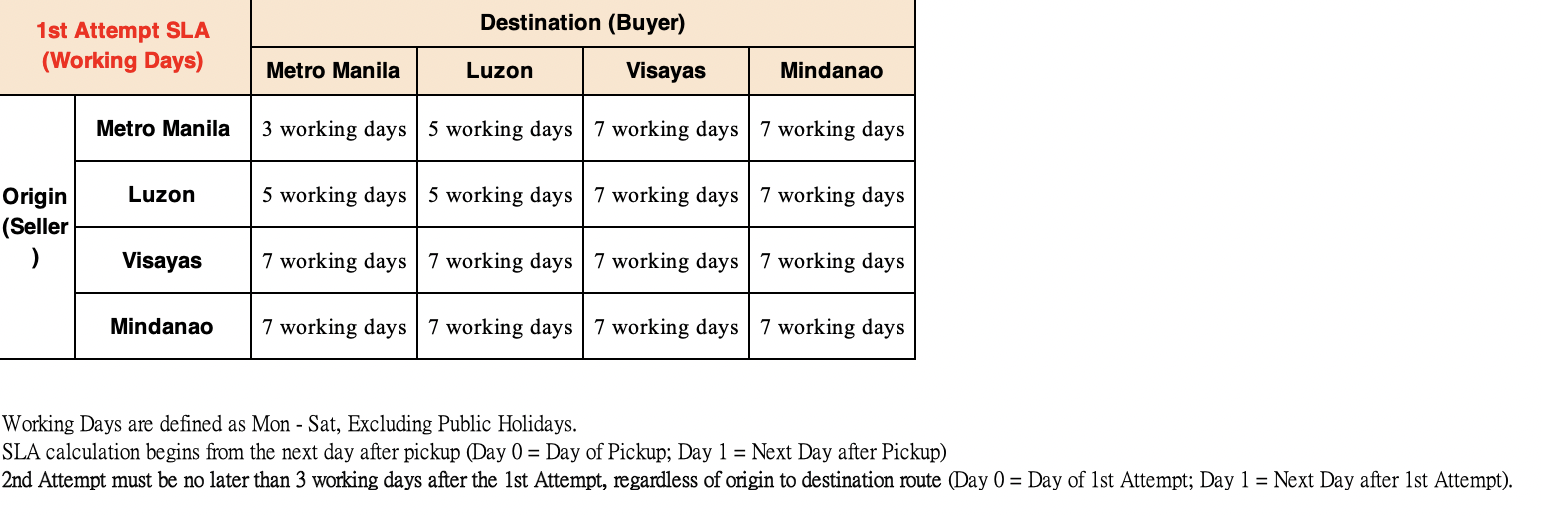

## Step 1: BusDay Count


In [12]:
data['pick'] = pd.to_datetime(data['pick'], unit='s')
data['1st_deliver_attempt'] = pd.to_datetime(data['1st_deliver_attempt'],  unit='s')
data['2nd_deliver_attempt'] = pd.to_datetime(data['2nd_deliver_attempt'],  unit='s')

In [13]:
data.head(5)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress
0,2215676524,2020-03-02 08:39:57,2020-03-05 05:09:18,NaT,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...
1,2219624609,2020-03-04 08:19:28,2020-03-06 02:53:56,2020-03-10 00:02:56,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ..."
2,2220979489,2020-03-04 07:20:34,2020-03-06 01:56:19,NaT,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M..."
3,2221066352,2020-03-05 14:36:56,2020-03-07 04:45:41,NaT,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number..."
4,2222478803,2020-03-04 10:38:25,2020-03-06 07:41:40,NaT,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...


KeyPoint 1: Check Time Zone

In [14]:
!date +"%Z %z"

UTC +0000


In [15]:
#All time formats are stored in epoch time based on Local Time (GMT+8).
#用UTC +0000 計算 UTC+8的，會慢8hr ->加回來

data['pick'] = pd.to_datetime(data['pick'], format='%Y-%m-%d')+pd.Timedelta('08:00:00')
data['1st_deliver_attempt'] = pd.to_datetime(data['1st_deliver_attempt'], format='%Y-%m-%d')+pd.Timedelta('08:00:00')
data['2nd_deliver_attempt'] = pd.to_datetime(data['2nd_deliver_attempt'], format='%Y-%m-%d')+pd.Timedelta('08:00:00')

In [16]:
resumetable(data)

Dataset Shape: (3176313, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,orderid,int64,0,3176313,2215676524,2219624609,2220979489,21.59892
1,pick,datetime64[ns],0,236418,2020-03-02 16:39:57,2020-03-04 16:19:28,2020-03-04 15:20:34,16.11143
2,1st_deliver_attempt,datetime64[ns],0,876961,2020-03-05 13:09:18,2020-03-06 10:53:56,2020-03-06 09:56:19,19.36947
3,2nd_deliver_attempt,datetime64[ns],1819311,529216,NaT,2020-03-10 08:02:56,NaT,17.83449
4,buyeraddress,object,0,3176313,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...",21.59892
5,selleraddress,object,0,3176313,Pantranco vill. 417 Warehouse# katipunan 532 (...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",21.59892


KeyPoint 2: Business Day Count

In [17]:
data.head(5)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,NaT,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ..."
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,NaT,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M..."
3,2221066352,2020-03-05 22:36:56,2020-03-07 12:45:41,NaT,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number..."
4,2222478803,2020-03-04 18:38:25,2020-03-06 15:41:40,NaT,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...


In [18]:
min(data['1st_deliver_attempt'])

Timestamp('2020-03-02 14:45:45')

In [19]:
#第二次如果是空值，代表第一次就送成功
#最後應該是要找第二次-第一次時間超過幾天的，所以ＮＡ塞負數讓他減出來負的，就不會貼到
data.loc[data['2nd_deliver_attempt'].isna(),'2nd_deliver_attempt']=pd.Timestamp('1991-01-01')

In [20]:
busday_cnt_cond1 = np.busday_count(
    data['pick'].values.astype('datetime64[D]'),
    data['1st_deliver_attempt'].values.astype('datetime64[D]'),
    weekmask=[1,1,1,1,1,1,0],
    holidays = ['2020-03-08',
               '2020-03-25',
               '2020-03-30',
               '2020-03-31']
)

In [21]:
busday_cnt_cond2 = np.busday_count(
    data['1st_deliver_attempt'].values.astype('datetime64[D]'),
    data['2nd_deliver_attempt'].values.astype('datetime64[D]'),
    weekmask=[1,1,1,1,1,1,0],
    holidays = ['2020-03-08',
               '2020-03-25',
               '2020-03-30',
               '2020-03-31']
)

In [22]:
data['busday_cnt_cond1'] = busday_cnt_cond1
data['busday_cnt_cond2'] = busday_cnt_cond2

In [23]:
data.head(3)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress,busday_cnt_cond1,busday_cnt_cond2
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,1991-01-01 00:00:00,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,3,-9134
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",2,3
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,1991-01-01 00:00:00,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",2,-9135


## Step 2: Extract destination infomation
* Metro Manila
* Luzon
* Visayas
* Mindanao


In [24]:
#全部小寫
data['buyeraddress'][6]

'Ka-insong stockholme Lhuilier, polanco. malen SHOP)) Metro Manila'

In [25]:
data['buyeraddress'][6].lower()

'ka-insong stockholme lhuilier, polanco. malen shop)) metro manila'

In [26]:
data['buyeraddress'] = data['buyeraddress'].apply(lambda x: x.lower())
data['selleraddress'] = data['selleraddress'].apply(lambda x: x.lower())

[ low efficiency ] 4 conditions to extract city name


In [27]:
data['buyeraddress'][0]

'baging ldl buenavista,patag.cagayan buagsong,cordova,cebu mt.vernon buolding, habagat lordman natl metro manila'

In [28]:
data['buyeraddress'][0].split()

['baging',
 'ldl',
 'buenavista,patag.cagayan',
 'buagsong,cordova,cebu',
 'mt.vernon',
 'buolding,',
 'habagat',
 'lordman',
 'natl',
 'metro',
 'manila']

In [29]:
buyeraddress_city = []

for i in  data['buyeraddress']:
  cnt = 0;
  if 'manila' in i.split()[-1] : 
    buyeraddress_city.append('metro manila')
    cnt+=1
  if 'luzon' in i.split()[-1] : 
    buyeraddress_city.append('luzon')
    cnt+=1
  if 'visayas' in i.split()[-1] : 
    buyeraddress_city.append('visayas')
    cnt+=1
  if 'mindanao' in i.split()[-1]: 
    buyeraddress_city.append('mindanao')
    cnt+=1
  if cnt>2:
    print(i)

In [30]:
len(buyeraddress_city)

3176313

In [31]:
selleraddress_city = []

for i in  data['selleraddress']:
  cnt = 0;
  if 'manila' in i.split()[-1] : 
    selleraddress_city.append('metro manila')
    cnt+=1
  elif 'luzon' in i.split()[-1] : 
    selleraddress_city.append('luzon')
    cnt+=1
  elif 'visayas' in i.split()[-1] : 
    selleraddress_city.append('visayas')
    cnt+=1
  elif 'mindanao' in i.split()[-1]: 
    selleraddress_city.append('mindanao')
    cnt+=1
  if cnt>2:
    print(i)

In [32]:
len(selleraddress_city)

3176313

In [33]:
data['buyeraddress_city'] = buyeraddress_city
data['selleraddress_city'] = selleraddress_city

In [34]:
data.head(3)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress,busday_cnt_cond1,busday_cnt_cond2,buyeraddress_city,selleraddress_city
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,1991-01-01 00:00:00,"baging ldl buenavista,patag.cagayan buagsong,c...",pantranco vill. 417 warehouse# katipunan 532 (...,3,-9134,metro manila,metro manila
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom casanas site1 masiyan 533a stol...,"bldg 210a moras c42b 2b16,168 church) complex ...",2,3,metro manila,metro manila
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,1991-01-01 00:00:00,"21-o lumangdaan,capitangan,abucay,bataan .bign...","#66 150-c, drive, milagros joe socorro metro m...",2,-9135,metro manila,metro manila


## Filter
Create SLA Matrix

In [35]:
SLA_matrix = pd.DataFrame({'buyeraddress_city':['metro manila','luzon','visayas','mindanao','metro manila','luzon','visayas','mindanao','metro manila','luzon','visayas','mindanao','metro manila','luzon','visayas','mindanao']})

In [36]:
SLA_matrix['selleraddress_city'] = ['metro manila','metro manila','metro manila','metro manila',
                                    'luzon','luzon','luzon','luzon',
                                    'visayas','visayas','visayas','visayas',
                                    'mindanao','mindanao','mindanao','mindanao']

In [37]:
SLA_matrix['nolate_date'] = [3,5,7,7,
                             5,5,7,7,
                             7,7,7,7,
                             7,7,7,7]

In [38]:
SLA_matrix

,buyeraddress_city,selleraddress_city,nolate_date
0,metro manila,metro manila,3
1,luzon,metro manila,5
2,visayas,metro manila,7
3,mindanao,metro manila,7
4,metro manila,luzon,5
5,luzon,luzon,5
6,visayas,luzon,7
7,mindanao,luzon,7
8,metro manila,visayas,7
9,luzon,visayas,7


Left Join

In [39]:
data = data.merge(SLA_matrix,on = ['buyeraddress_city','selleraddress_city'],how='left')

In [40]:
data.head(3)

,orderid,pick,1st_deliver_attempt,2nd_deliver_attempt,buyeraddress,selleraddress,busday_cnt_cond1,busday_cnt_cond2,buyeraddress_city,selleraddress_city,nolate_date
0,2215676524,2020-03-02 16:39:57,2020-03-05 13:09:18,1991-01-01 00:00:00,"baging ldl buenavista,patag.cagayan buagsong,c...",pantranco vill. 417 warehouse# katipunan 532 (...,3,-9134,metro manila,metro manila,3
1,2219624609,2020-03-04 16:19:28,2020-03-06 10:53:56,2020-03-10 08:02:56,coloma's quzom casanas site1 masiyan 533a stol...,"bldg 210a moras c42b 2b16,168 church) complex ...",2,3,metro manila,metro manila,3
2,2220979489,2020-03-04 15:20:34,2020-03-06 09:56:19,1991-01-01 00:00:00,"21-o lumangdaan,capitangan,abucay,bataan .bign...","#66 150-c, drive, milagros joe socorro metro m...",2,-9135,metro manila,metro manila,3


In [41]:
(data['busday_cnt_cond1']>data['nolate_date']).value_counts()

False    2734919
True      441394
dtype: int64

In [42]:
#第一次超過No Late的 or 第二次超過3天
data['is_late'] = np.where((data['busday_cnt_cond1']>data['nolate_date']) | (data['busday_cnt_cond2']>3),1,0)

In [43]:
data.columns

Index(['orderid', 'pick', '1st_deliver_attempt', '2nd_deliver_attempt',
       'buyeraddress', 'selleraddress', 'busday_cnt_cond1', 'busday_cnt_cond2',
       'buyeraddress_city', 'selleraddress_city', 'nolate_date', 'is_late'],
      dtype='object')

In [44]:
submit = data[['orderid','is_late']]

In [45]:
submit.shape

(3176313, 2)

In [46]:
submit.to_csv('/content/submit.csv',index=False)

In [ ]:
!kaggle competitions submit -c open-shopee-code-league-logistic -f /content/submit.csv -m "try_2021"

100% 41.2M/41.2M [00:01<00:00, 37.0MB/s]
Successfully submitted to [Open] Shopee Code League - Logistics

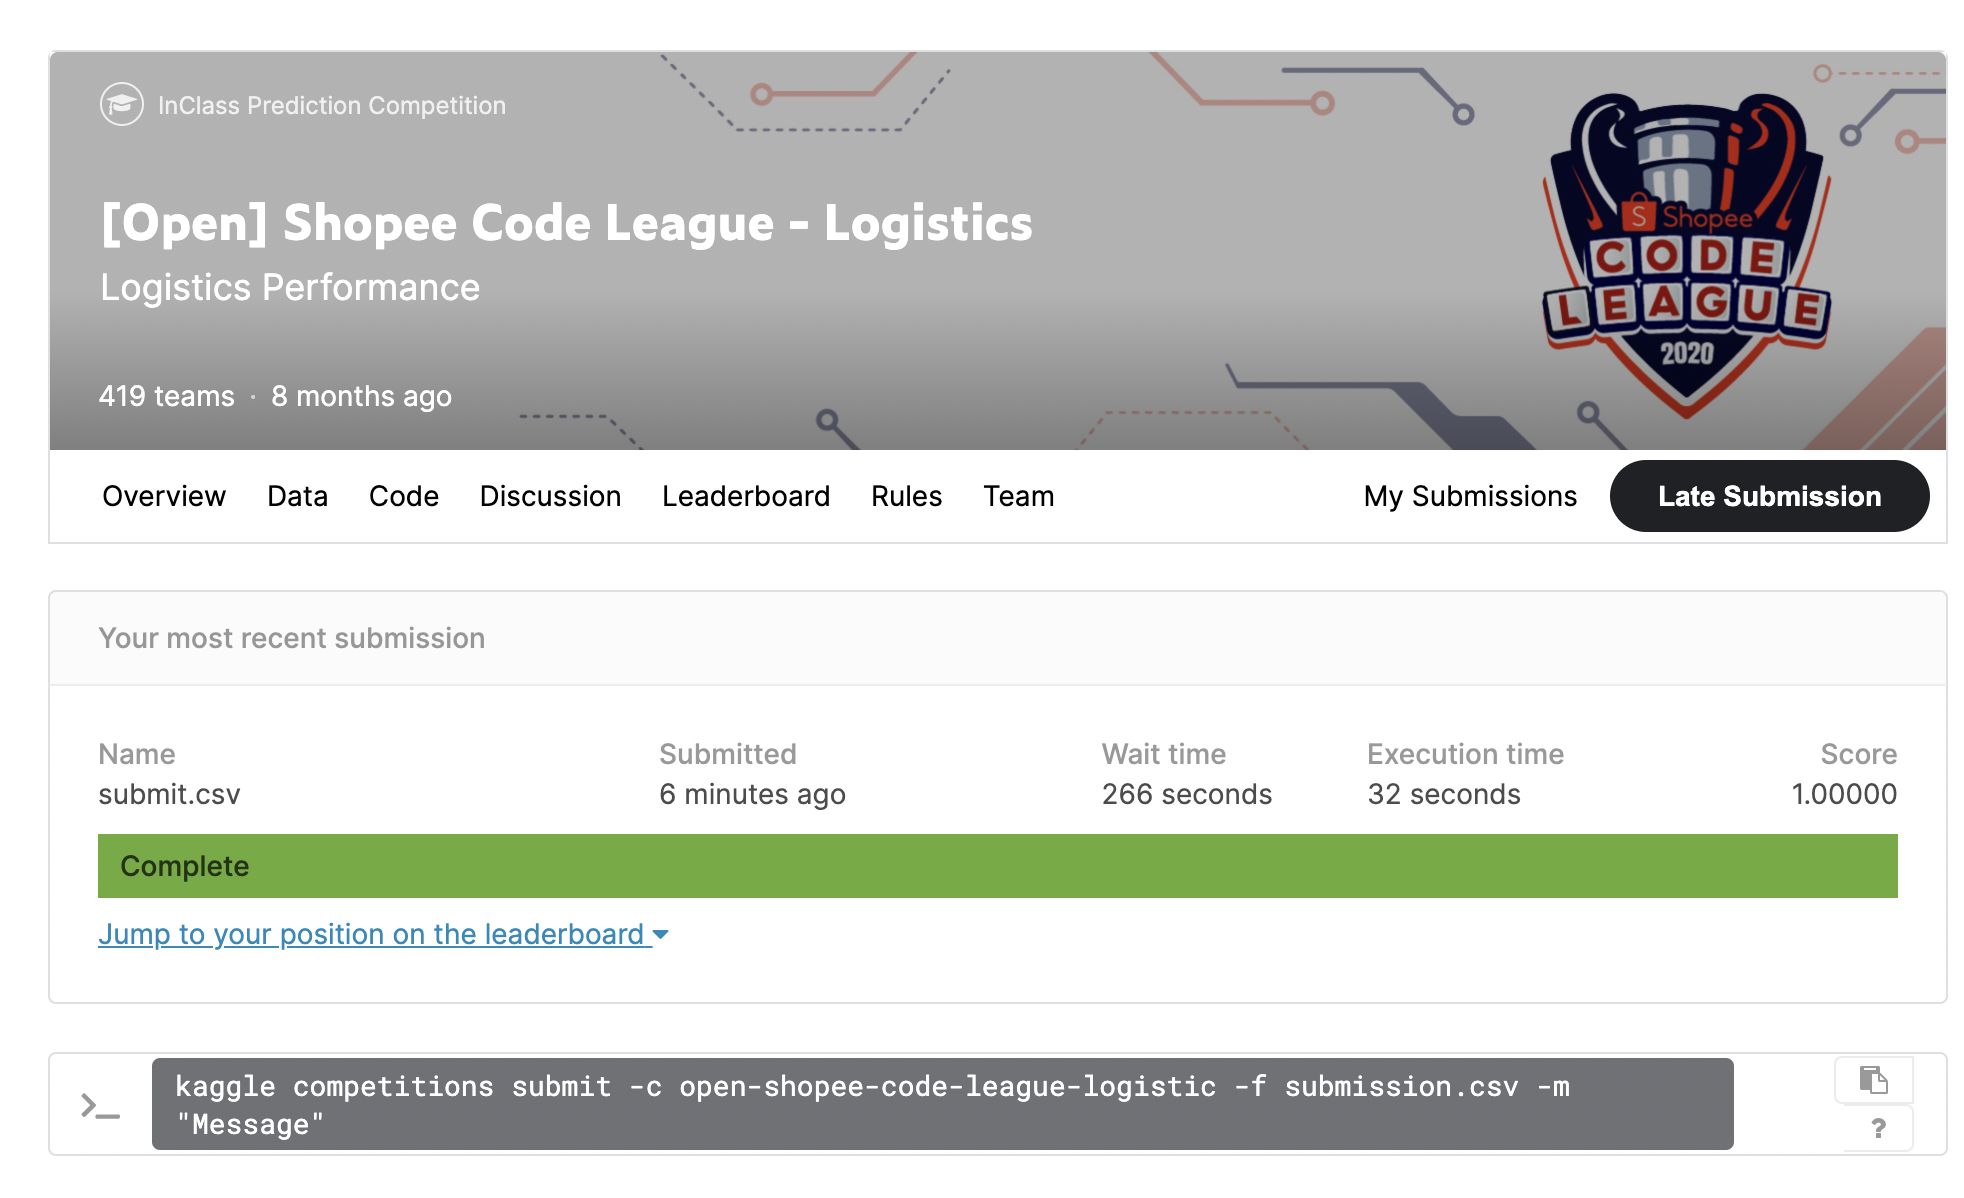